In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.utils import shuffle

import sys
sys.path.append('../src/')
import aposch_cv_src as aposch

import os

In [2]:
def list_granule_paths(tile='10SFH',
                       year=2020,
                       hls_dir='../data/hls_23feb23',
                       sats=['L30','S30']):
    
    tile_slashes = f'{tile[:2]}/{tile[2]}/{tile[3]}/{tile[4]}'
    granule_paths = []
    
    for sat in sats:
        path = f'{hls_dir}/{sat}/{year}/{tile_slashes}'
        these_granules = os.listdir(path)
        granule_paths += [path+'/'+granule for granule in these_granules]
        
    return granule_paths

In [3]:
def list_filtered_paths(granule_paths,
                        pixel,
                        remove_if_clouds=True,
                        remove_if_shadow=True,
                        remove_if_adjacent=True,
                        ):
    granules = [gp[-34:] for gp in granule_paths]
    nbr_g = len(granules)
    band = 'Fmask'
    filtered_paths = []
    
    for i in range(nbr_g):
        tiff = f'{granules[i]}.{band}.tif'
        path = f'{granule_paths[i]}/{tiff}'
        with rasterio.open(path) as src:
            arr = src.read(1)
        value = arr[pixel[0],pixel[1]]
        binary = '{0:b}'.format(value).zfill(8)
        has_clouds = bool(int(binary[-2]))
        has_adjacent = bool(int(binary[-3]))
        has_shadow = bool(int(binary[-4]))
        remove = ((has_clouds and remove_if_clouds) or
                  (has_adjacent and remove_if_adjacent) or
                  (has_shadow and remove_if_shadow))
        
        if remove == False: 
            filtered_paths.append(granule_paths[i])
            
    print(f'After filtering, there are {len(filtered_paths)} granules remaining.')

    return filtered_paths
   

We need to deal with bands. We want to be able to list the band in English:
- Blue
- Green
- Red
- NIR
- SWIR1
- SWIR2


In [6]:
def gather_data(granule_paths, band, pixel):
    
    L30_dict = {'Blue':'B02', 'Green':'B03', 'Red':'B04',
               'NIR':'B05', 'SWIR1':'B06', 'SWIR2':'B07'}
    S30_dict = {'Blue':'B02', 'Green':'B03', 'Red':'B04',
               'NIR':'B8A', 'SWIR1':'B11', 'SWIR2':'B12'}
    
    granules = [gp[-34:] for gp in granule_paths]
    nbr_g = len(granules)
    refls = []
    DOYs = [int(g[-15:-12]) for g in granules]
    sats = [g[4:7] for g in granules]
    
    for i in range(nbr_g):
        if sats[i] == 'L30':
            band_code = L30_dict[band]
        if sats[i] == 'S30':
            band_code = S30_dict[band]
        tiff = f'{granules[i]}.{band_code}.tif'
        path = f'{granule_paths[i]}/{tiff}'
        with rasterio.open(path) as src:
            arr = src.read(1)
        value = arr[pixel[0],pixel[1]]
        refls.append(value)

    return refls, DOYs, sats

In [7]:
def explore_data(refls, DOYs, sats, save_loc, tags,
                 save=True, show=False):
    title = f'Reflectances for {" ".join(str(t) for t in tags)}'
    file_name = f'EDA_{"_".join(str(t) for t in tags)}.png'

    la = sum([sat == 'L30' for sat in sats]) # last landsat
    
    plt.figure(figsize=(20, 6))
    plt.scatter(DOYs[:la],
            refls[:la],
            c='orange',
            label='L30')
    plt.scatter(DOYs[la:],
            refls[la:],
            c='purple',
            label='S30')
    plt.title(title, size=14)
    plt.legend(loc='best')
    plt.ylabel('Reflectance')
    plt.xlabel('Day of Year')
    if save:
        plt.savefig(f'{save_loc}/{file_name}', bbox_inches='tight')
    if show:
        plt.show()
    

In [9]:
granule_paths = list_granule_paths()
filtered_paths = list_filtered_paths(granule_paths=granule_paths,
                   pixel=[900,50])

After filtering, there are 67 granules remaining.


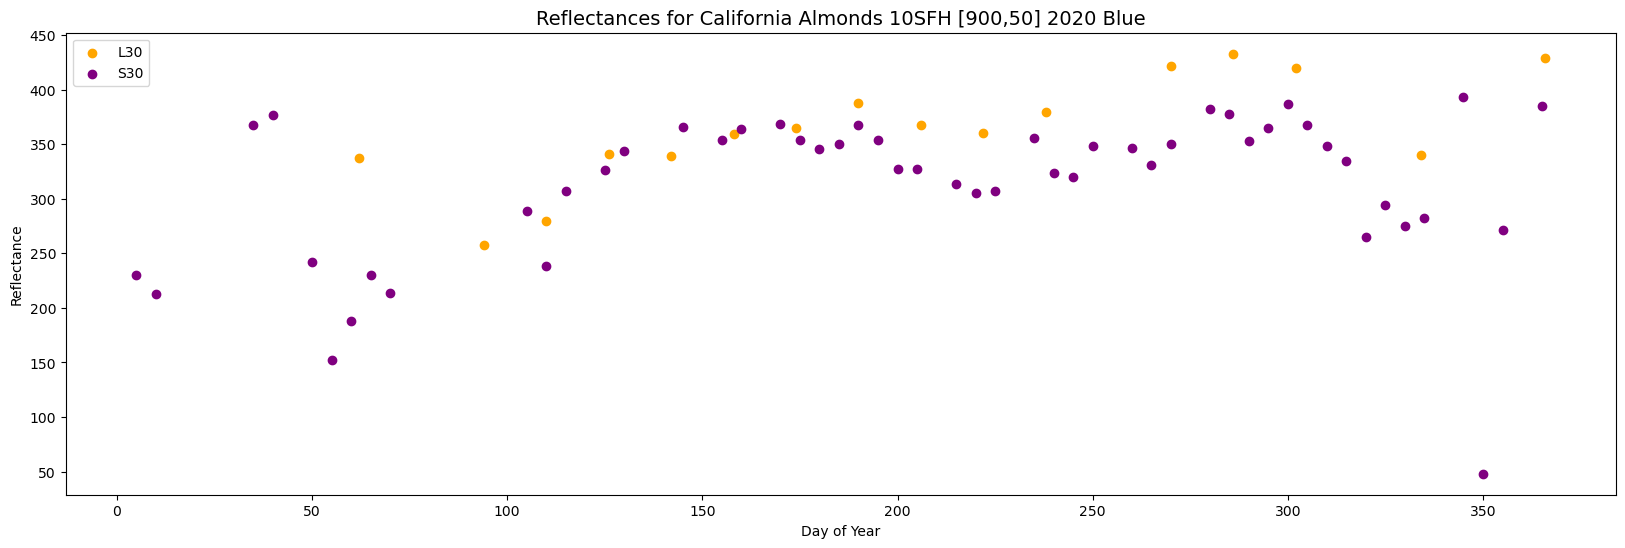

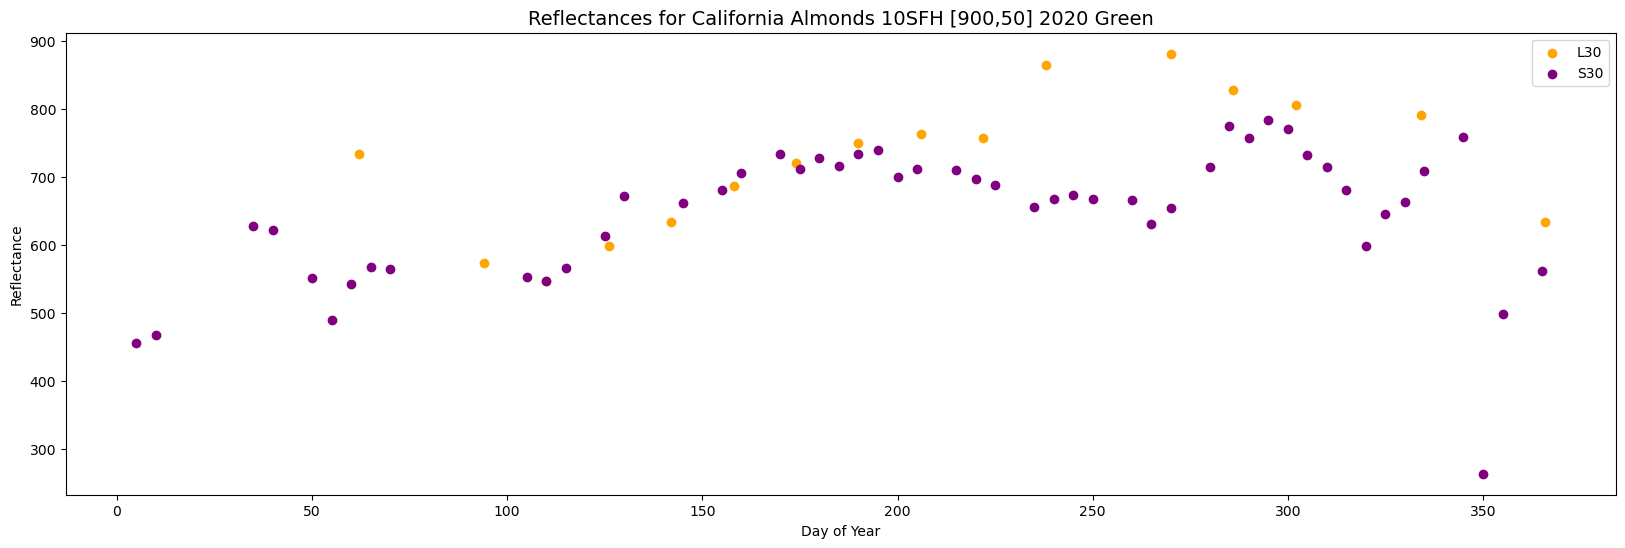

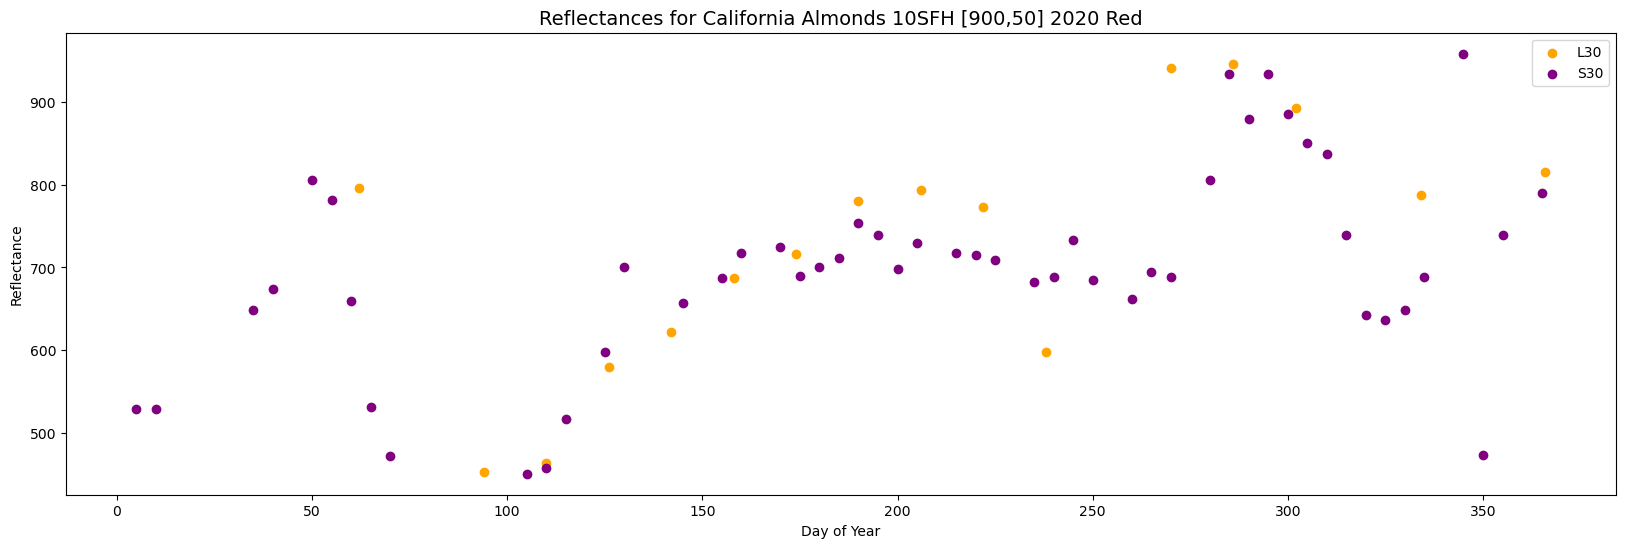

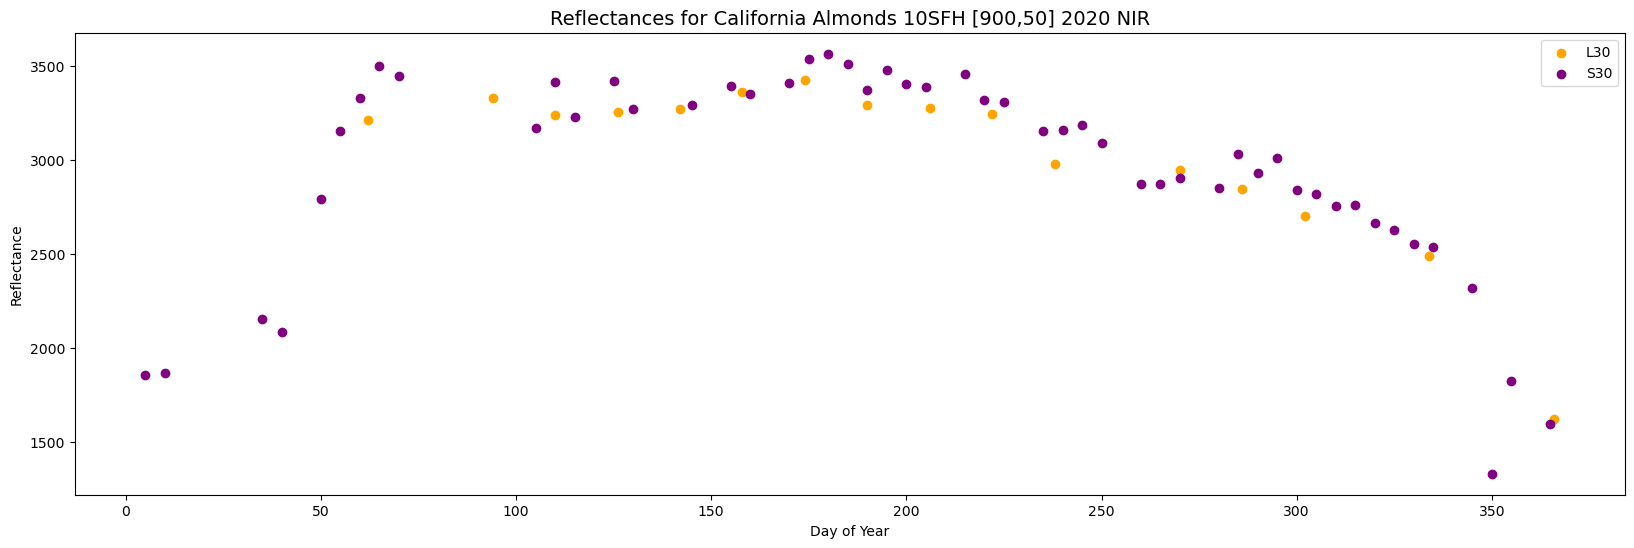

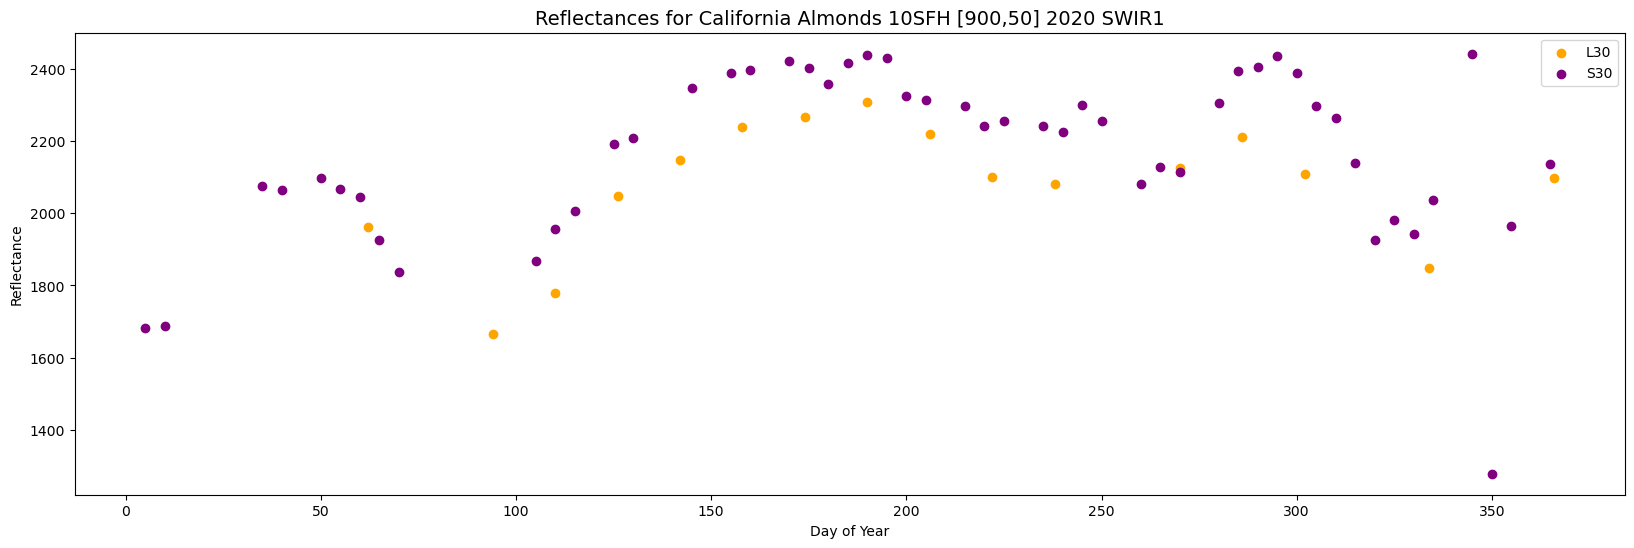

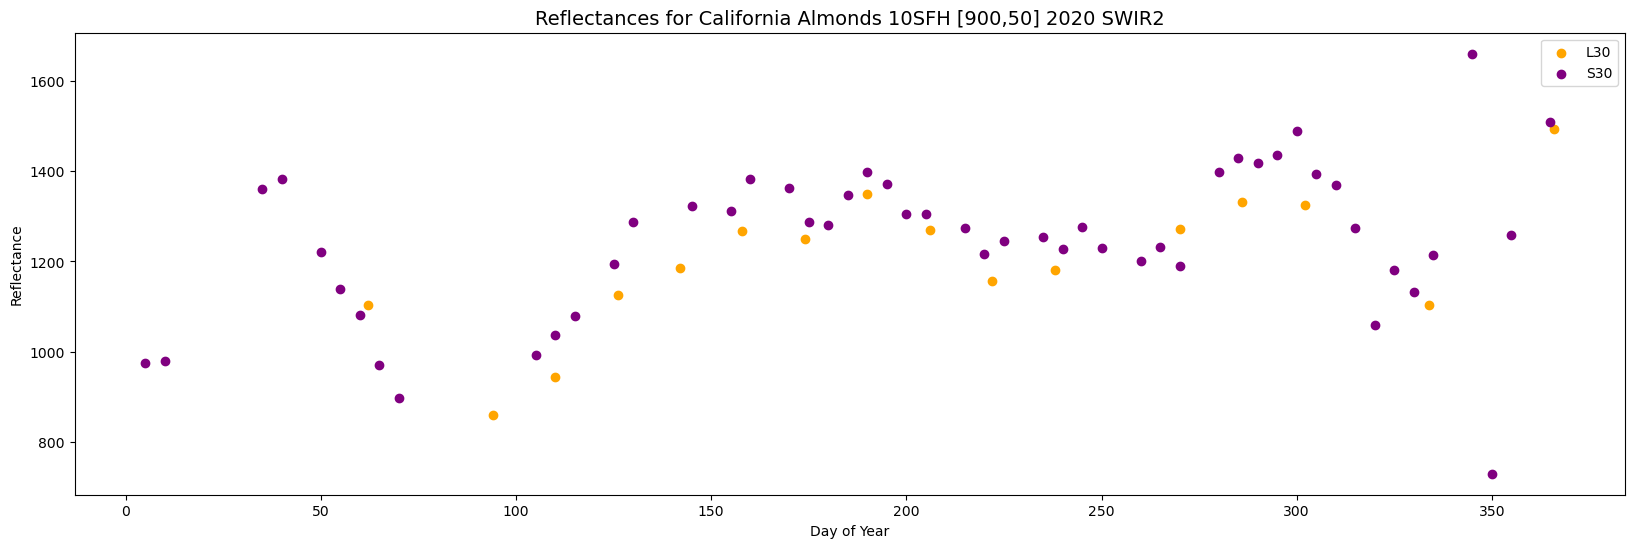

In [10]:
bands = ['Blue','Green','Red','NIR','SWIR1','SWIR2']

for band in bands:
    refls, DOYs, sats = gather_data(filtered_paths,
                                band,
                                pixel=[900,50])
    explore_data(refls, DOYs, sats,
             save_loc='../figures',
             tags = ['California','Almonds','10SFH','[900,50]',2020,band],
             show=True)

Note: based on above plots, we see that Landsat observations are consistently different from Sentinel observations. Because there are more Sentinel observations, this means that if I composite to 14-day periods and take the median, then I'll usually be tossing out the Landsat observations during the median calculation.

(That is probably ultimately a small-potatoes issue.)

Next: make these same plots but for 2021 or 2019, etc.

In [ ]:
refls, DOYs, sats = gather_data(filtered_paths,
                                band='B03',
                                pixel=[900,50])

In [ ]:
explore_data(refls, DOYs, sats,
             save_loc='../figures',
             tags = ['California','Almonds','10SFH','[900,50]',2020,'B03'],
             show=True)